In [84]:
import os
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import gc
from functools import reduce
import ssl
import urllib
import cv2

In [85]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import AveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras import losses
from keras import metrics

In [86]:
input_shape = (250, 250, 3)

model = Sequential([
    Conv2D(64, (3, 3), input_shape=input_shape, padding='same', activation='relu'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same',),
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
    Flatten(),
#    Dense(12544, activation='selu'),
#    Dense(6274, activation='selu'),
    Dense(3136, activation='selu'),
    Dense(1568, activation='selu'),
    Dense(784, activation='selu'),
    Dense(392, activation='selu'),
    Dense(196, activation='selu'),
    Dense(98, activation='selu'),
    Dense(49, activation='selu'),
    Dense(25, activation='selu'),
    Dense(18, activation='softmax')
])
# 25088
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 250, 250, 64)      1792      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 250, 250, 64)      36928     
_________________________________________________________________
average_pooling2d_6 (Average (None, 125, 125, 64)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 125, 125, 128)     73856     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 125, 125, 128)     147584    
_________________________________________________________________
average_pooling2d_7 (Average (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 62, 62, 256)       295168    
__________

In [87]:
save_model_name = "after_hackerthon_softmax.model"

In [88]:
def getDf(path,W):
    o = {}
    o['name'] = []
    o['image'] = []
    for p in os.listdir(path):
        for filename in os.listdir(path+"/"+p):
            o['name'].append(p)
            oriimg = plt.imread(path+"/"+p+"/"+filename)
            height, width, depth = oriimg.shape
            imgScale = W/width if width>height else W/height
            newX,newY = width*imgScale, height*imgScale
            newSize = newX if newX>newY else newY
            newimg = cv2.resize(oriimg,(int(newSize),int(newSize)))/127.5
            o['image'].append(newimg.tolist())
    return o

In [89]:
data = pd.DataFrame.from_dict(getDf('./data',250.))

In [90]:
def getTrainSet(d):
    a = d['image'].tolist()
    x_train = reduce(lambda x,y: np.concatenate((np.array(x).reshape(-1,250,250,3),np.array(y).reshape(-1,250,250,3)),axis=0),a)
    y_train = pd.get_dummies(data['name'])
    return x_train,y_train

In [91]:
x_train,y_train = getTrainSet(data)

In [9]:
# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

In [10]:
del data

gc.collect()

7

In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [12]:
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_acc')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)


In [13]:
hist = model.fit(x=x_train, y=y_train, validation_split=0.33,epochs=20,batch_size=32, callbacks=[model_checkpoint,reduce_lr, early_stop])

Train on 121 samples, validate on 60 samples
Epoch 1/20
121/121 [==============================] - 82s 682ms/step - loss: 4.8463 - acc: 0.5335 - val_loss: 5.8534 - val_acc: 0.6333
Epoch 2/20
121/121 [==============================] - 80s 662ms/step - loss: 5.8710 - acc: 0.6322 - val_loss: 5.8534 - val_acc: 0.6333
Epoch 3/20
121/121 [==============================] - 69s 568ms/step - loss: 5.3815 - acc: 0.6630 - val_loss: 4.9677 - val_acc: 0.6889
Epoch 4/20
121/121 [==============================] - 67s 557ms/step - loss: 5.1767 - acc: 0.6758 - val_loss: 4.9677 - val_acc: 0.6889
Epoch 5/20
121/121 [==============================] - 67s 557ms/step - loss: 5.1767 - acc: 0.6758 - val_loss: 4.9677 - val_acc: 0.6889
Epoch 6/20
121/121 [==============================] - 71s 588ms/step - loss: 5.1767 - acc: 0.6758 - val_loss: 4.9677 - val_acc: 0.6889
Epoch 7/20
121/121 [==============================] - 72s 597ms/step - loss: 5.1767 - acc: 0.6758 - val_loss: 4.9677 - val_acc: 0.6889
Epoch 8/20

In [93]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 250, 250, 64)      1792      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 250, 250, 64)      36928     
_________________________________________________________________
average_pooling2d_6 (Average (None, 125, 125, 64)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 125, 125, 128)     73856     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 125, 125, 128)     147584    
_________________________________________________________________
average_pooling2d_7 (Average (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 62, 62, 256)       295168    
__________

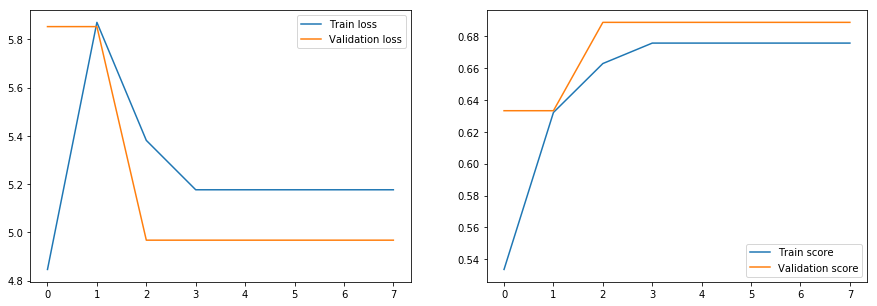

In [14]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(hist.epoch, hist.history["loss"], label="Train loss")
ax_loss.plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(hist.epoch, hist.history["acc"], label="Train score")
ax_score.plot(hist.epoch, hist.history["val_acc"], label="Validation score")
ax_score.legend()

In [15]:
def imgResize(url,W):
    context = ssl._create_unverified_context()
    resp =  urllib.request.urlopen(url, context=context)
    oriimg = np.asarray(bytearray(resp.read()), dtype="uint8")
    oriimg = cv2.imdecode(oriimg, cv2.IMREAD_ANYCOLOR)
    oriimg = cv2.cvtColor(oriimg,cv2.COLOR_BGR2RGB)
    height, width, depth = oriimg.shape
    imgScale = W/width if width>height else W/height
    newX,newY = width*imgScale, height*imgScale
    newSize = newX if newX>newY else newY
    newimg = cv2.resize(oriimg,(int(newSize),int(newSize)))/127.5
    return np.array(newimg).reshape(-1,int(newSize),int(newSize),3)

In [16]:
def getDf(path,W):
    o = {}
    o['name'] = []
    o['image'] = []
    for p in os.listdir(path):
        for filename in os.listdir(path+"/"+p):
            o['name'].append(p)
            oriimg = plt.imread(path+"/"+p+"/"+filename)
            height, width, depth = oriimg.shape
            imgScale = W/width if width>height else W/height
            newX,newY = width*imgScale, height*imgScale
            newSize = newX if newX>newY else newY
            newimg = cv2.resize(oriimg,(int(newSize),int(newSize)))
            o['image'].append(newimg.tolist())
    return o

In [17]:
def getName(m,n,img):
    return pd.Categorical(n).categories[np.argmax(m.predict(img))]

In [18]:
image = imgResize("https://diag.tactri.gov.tw/public/UploadDgnsResultImage/6519/2d8e4ed2-833c-433c-ac7d-3401af085a78.jpg",250.)

In [19]:
data = pd.DataFrame.from_dict(getDf('./data',250.))

In [20]:
# 萎凋病 
getName(model,data['name'],image)

'Rhizoctonia sp.引起之立枯病'

In [21]:
def imgResize2(i,W):
    oriimg = np.array(i)
    height, width, depth = oriimg.shape
    imgScale = W/width if width>height else W/height
    newX,newY = width*imgScale, height*imgScale
    newSize = newX if newX>newY else newY
    newimg = cv2.resize(oriimg,(int(newSize),int(newSize)))/127.5
    return np.array(newimg).reshape(-1,int(newSize),int(newSize),3)

In [22]:
j=0
for i in range(data.shape[0]):
    k = data.iloc[i]
    if k['name'] == getName(model,data['name'],imgResize2(k['image'],250)):
        j+=1

In [23]:
j/data.shape[0]

0.0055248618784530384

In [73]:
a = pd.read_csv('./concatfinal.csv')

In [82]:
n = 100
print(a.iloc[n]['name'])
print(getName(model,data['name'],imgResize(a.iloc[n]['image'],250.)))

炭疽病
Rhizoctonia sp.引起之立枯病


In [49]:
model.predict_classes(imgResize(a.iloc[n]['image'],250.))

array([1])

In [51]:
model.predict(imgResize(a.iloc[n]['image'],250.))

array([[0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        0., 1.]], dtype=float32)

In [72]:
b = pd.Categorical(data['name'])

In [83]:
for name,i in zip(b.categories,model.predict(imgResize(a.iloc[n]['image'],250.))[0]):
    if i > 0:
        print(name)

Rhizoctonia sp.引起之立枯病
Rhizopus sp.引起之真菌性病害
莖腐病
薊馬類
非洲菊斑潛蠅


In [80]:
b.categories

Index(['Phoma sp.引起之真菌性病害', 'Rhizoctonia sp.引起之立枯病', 'Rhizopus sp.引起之真菌性病害',
       '炭疽病', '猝倒病', '疫病', '白粉病', '白絹病', '白銹病', '立枯病', '細菌性葉斑病', '莖腐病', '萎凋病',
       '薊馬類', '蠅類', '鐮孢菌引起之萎凋病', '青枯病', '非洲菊斑潛蠅'],
      dtype='object')